In [2]:
%matplotlib notebook

import os
import sys
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

import numpy as np
import scipy as sp
from scipy.stats import rankdata
import h5py
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid

sys.path.append('..')
sys.path.append('../lib')
import interlacer.models as models
import interlacer.layers as layers
import interlacer.losses as losses
import interlacer.data_generator as data_generator
import interlacer.fastmri_data_generator as fastmri_data_generator
import interlacer.utils as utils
import scripts.training_config as training_config
from scripts import filepaths

plt.rcParams.update({'font.size': 32})
%matplotlib inline

In [3]:
def get_corr(flattened_data,x,y):
    i = n*y+x

    A = flattened_data
    b = flattened_data[:,i]
    cov = np.dot(b.T - b.mean(), A - A.mean(axis=0))/flattened_data.shape[0] 
    corr = cov / (np.std(b, ddof=1) * np.std(A, axis=0, ddof=1))
    return corr

def get_clipped_corr(flattened_data,x,y,cutoff):
    corr = get_corr(flattened_data,x,y)
    corr_clip = corr.copy()
    corr_clip[np.abs(corr)<cutoff]=0
    n = int(np.sqrt(flattened_data.shape[1]))
    return corr_clip.reshape((n,n))

# Brain Analysis

In [4]:
train_data,_ = data_generator.get_mri_images()
n_images = train_data.shape[0]
n = train_data.shape[1]
train_data_re = np.reshape(np.real(train_data),(n_images,n*n))

train_data_fft = np.fft.fftshift(np.fft.fft2(train_data,axes=(1,2)),axes=(1,2))
train_data_fft_re = np.reshape(np.real(train_data_fft),(n_images,n*n))

In [ ]:
x,y = 100,150
half_n = int(n/2)
cutoff=0

brain_img_corr_clip = get_clipped_corr(train_data_re,x,y,cutoff)
brain_fft_corr_clip = get_clipped_corr(train_data_fft_re,x,y,cutoff)

# MNIST Analysis

In [7]:
from tensorflow.keras.datasets import mnist

def get_mnist_images():
    """Load MNIST images, normalized to [0,1]."""
    (img_train, _), (img_test, _) = mnist.load_data()
    img_train = img_train / 255.
    img_test = img_test / 255.
    return img_train, img_test

In [8]:
train_data,_ = get_mnist_images()
train_data2 = np.concatenate([train_data,np.rot90(train_data,axes=(1,2))],axis=0)
train_data3 = np.concatenate([train_data2,np.rot90(np.rot90(train_data,axes=(1,2)),axes=(1,2))],axis=0)
train_data4 = np.concatenate([train_data3,np.rot90(np.rot90(np.rot90(train_data,axes=(1,2)),axes=(1,2)),axes=(1,2))],axis=0)

n_images = train_data.shape[0]
n = train_data.shape[1]

train_data_re = np.reshape(np.real(train_data4),(4*n_images,n*n))

train_data_fft = np.fft.fftshift(np.fft.fft2(train_data4,axes=(1,2)),axes=(1,2))
train_data_fft_re = np.reshape(np.real(train_data_fft),(4*n_images,n*n))

In [ ]:
x,y = 9,16
half_n = int(n/2)
cutoff=0

mnist_img_corr_clip = get_clipped_corr(train_data_re,x,y,cutoff)
mnist_fft_corr_clip = get_clipped_corr(train_data_fft_re,x,y,cutoff)


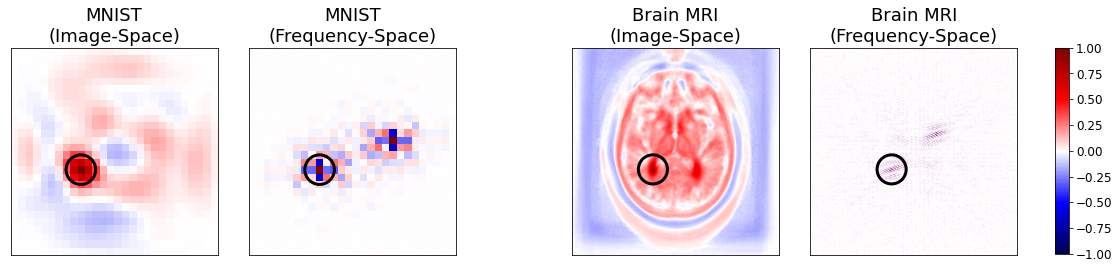

In [10]:
fig, axes = plt.subplots(1, 6, figsize=(20,6),gridspec_kw=dict(width_ratios=[8,8,2,8,8,3]))
fs = 18
ax4 = axes[4]
ax3 = axes[3]
ax1 = axes[1]
ax0 = axes[0]
ax2 = axes[2]
ax5 = axes[5]

x_brain = 100
y_brain = 150
im3 = ax3.imshow(brain_img_corr_clip,cmap='seismic',vmin=-1,vmax=1)
im4 = ax4.imshow(brain_fft_corr_clip,cmap='seismic',vmin=-1,vmax=1)
circle3 = plt.Circle( ( x_brain, y_brain ), 18, fill=False, lw=3)
circle4 = plt.Circle( ( x_brain, y_brain ), 18, fill=False, lw=3)
ax3.add_patch(circle3)
ax4.add_patch(circle4)


x_mnist = 9
y_mnist = 16
im0 = ax0.imshow(mnist_img_corr_clip,cmap='seismic',vmin=-1,vmax=1)
im1 = ax1.imshow(mnist_fft_corr_clip,cmap='seismic',vmin=-1,vmax=1)
circle0 = plt.Circle( ( x_mnist, y_mnist ), 2, fill=False, lw=3)
circle1 = plt.Circle( ( x_mnist, y_mnist ), 2, fill=False, lw=3)
ax0.add_patch(circle0)
ax1.add_patch(circle1)

ax0.set_title('MNIST\n(Image-Space)',fontsize=fs)
ax1.set_title('MNIST\n(Frequency-Space)',fontsize=fs)

ax3.set_title('Brain MRI\n(Image-Space)',fontsize=fs)
ax4.set_title('Brain MRI\n(Frequency-Space)',fontsize=fs)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(im1, ax=axes.ravel().tolist(),cax = fig.add_axes([0.85, 0.265, 0.01, 0.477]))
cb.ax.tick_params(labelsize='large')

ax2.remove()
ax5.remove()

plt.savefig('correlations.pdf',bbox_inches = 'tight',pad_inches = 0.2)

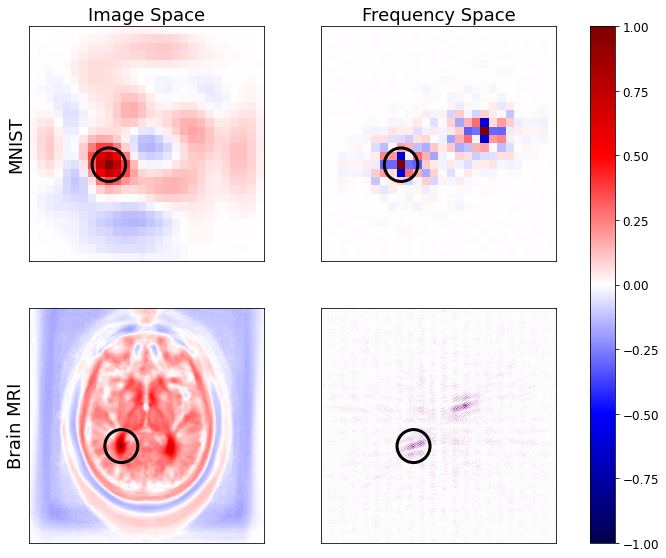

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12,9.5))
fs = 18

ax3 = axes[1][1]
ax1 = axes[0][1]
ax0 = axes[0][0]
ax2 = axes[1][0]

x_brain = 100
y_brain = 150
im2 = ax2.imshow(brain_img_corr_clip,cmap='seismic',vmin=-1,vmax=1)
im3 = ax3.imshow(brain_fft_corr_clip,cmap='seismic',vmin=-1,vmax=1)
circle3 = plt.Circle( ( x_brain, y_brain ), 18, fill=False, lw=3)
circle4 = plt.Circle( ( x_brain, y_brain ), 18, fill=False, lw=3)
ax2.add_patch(circle3)
ax3.add_patch(circle4)


x_mnist = 9
y_mnist = 16
im0 = ax0.imshow(mnist_img_corr_clip,cmap='seismic',vmin=-1,vmax=1)
im1 = ax1.imshow(mnist_fft_corr_clip,cmap='seismic',vmin=-1,vmax=1)
circle0 = plt.Circle( ( x_mnist, y_mnist ), 2, fill=False, lw=3)
circle1 = plt.Circle( ( x_mnist, y_mnist ), 2, fill=False, lw=3)
ax0.add_patch(circle0)
ax1.add_patch(circle1)

ax0.set_title('Image Space',fontsize=fs)
ax1.set_title('Frequency Space',fontsize=fs)

ax0.set_ylabel('MNIST',fontsize=fs)
ax2.set_ylabel('Brain MRI',fontsize=fs)

for ax in [ax0,ax1,ax2,ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_box_aspect(1)

cb = fig.colorbar(im1, ax=axes.ravel().tolist())
cb.ax.tick_params(labelsize='large')


plt.savefig('correlations_square.pdf',bbox_inches = 'tight',pad_inches = 0.2)